In [3]:
import numpy as np
import pandas as pd

from preprocess.preprocess_transaction_frequecy import preprocess_transaction_frequency
from preprocess.preprocess_init import preprocess_init
from preprocess.preprocess_time import preprocess_time
from preprocess.preprocess_change_card import preprocess_change_card
from preprocess.preprocess_mchno import preprocess_mchno
from preprocess.preprocess_special_features import preprocess_special_features
from preprocess.preprocess_conam import preprocess_conam
from preprocess.preprocess_train_test_split import preprocess_train_test_split

from util.generate_X_y import generate_X_y
from util.remove_outlier import remove_outlier
from util.generate_statistic import generate_statistic

from model.lgbm_model import LGBM_Model
from model.shap_importance import shap_importance
from model.plot import plot_importance

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [4]:
raw_bool_features = ['ecfg',
                     'flbmk',
                     'flg_3dsmk',
                     'insfg',
                     'ovrlt'
                      ]

raw_categorial_features = ['contp',
                           'stscd',
                           'etymd',
                           'stocn',
                           'mcc',
                           'csmcu',
                           'hcefg',
                           'bacno',
                           'cano',
                           'mchno',
                           'acqic',
                           'scity'
                            ] 

raw_contiuous_feautres = ['loctm',
                          'conam',
                          'iterm'
                           ]

transaction_frequency_feautres = ['cano_days_txkey_count',
                                  'cano_locdt_txkey_count',
                                  'bacno_locdt_mchno_txkey_count'
                                    ]

time_feautres = ['last_time_days',
                 'next_time_days',
                 'cano_locdt_global_time_std' 
                    ]


change_card_feautres = ['diff_locdt_with_last_trans_cano',
                        'diff_locdt_of_two_card'
                           ]

conam_feautres = ['cano_locdt_conam_min',
                  'cano_locdt_conam_max',
                  'diff_gtime_with_conam_zero_trans_locdt'
                   ]

mchno_features = ['bacno_mchno_locdt_head_tail_diff',
                  'cano_days_mchno_index',    
                    ]


special_feautures = ['mchno_in_normal_mchno_list',
                    'mchno_in_fraud_mchno_list',
                    'conam_in_fraud_conam_list',
                    'diff_with_first_fraud_locdt'
                               ]

features =  ( raw_bool_features 
            + raw_categorial_features
            + raw_contiuous_feautres
            + transaction_frequency_feautres
            + time_feautres
            + change_card_feautres
            + conam_feautres 
            + mchno_features
               )

label = 'fraud_ind'

In [6]:
preprocess_group = True
if preprocess_group:
    df_train_raw = pd.read_csv('data/train.csv')
    df_test_raw = pd.read_csv('data/test.csv')
    df = preprocess_init(df_train_raw, df_test_raw, raw_bool_features)
    df = preprocess_transaction_frequency(df)
    df = preprocess_time(df)
    df = preprocess_change_card(df)
    df = preprocess_mchno(df)
    df = preprocess_conam(df)
    df = preprocess_special_features(df)
    df.to_pickle('data/df_preprocessed.pkl')
else:
    df = pd.read_pickle('data/df_preprocessed.pkl')    

In [7]:
df_train, df_test = preprocess_train_test_split(df, raw_categorial_features)
X_train, y_train, groups, X_test = generate_X_y(df_train, df_test, label, features)
lgbm = LGBM_Model(features)
oof_preds_LGBM, df_sub_preds_LGBM, clf = lgbm.run(X_train, y_train, groups, X_test, lgbm.lgbm_averge_precision, n_splits = 10)

Starting LightGBM. Fold 1,Train shape: (1521787, 33), test shape: (421665, 33)
Training until validation scores don't improve for 100 rounds.
[100]	training's Averge Precision: 0.791544	valid_1's Averge Precision: 0.644891
[200]	training's Averge Precision: 0.834159	valid_1's Averge Precision: 0.663898
[300]	training's Averge Precision: 0.857481	valid_1's Averge Precision: 0.669548
[400]	training's Averge Precision: 0.874596	valid_1's Averge Precision: 0.672202
[500]	training's Averge Precision: 0.887319	valid_1's Averge Precision: 0.672951
[600]	training's Averge Precision: 0.898306	valid_1's Averge Precision: 0.673764
[700]	training's Averge Precision: 0.906783	valid_1's Averge Precision: 0.674154
[800]	training's Averge Precision: 0.913451	valid_1's Averge Precision: 0.674384
Early stopping, best iteration is:
[792]	training's Averge Precision: 0.912863	valid_1's Averge Precision: 0.674554
Starting LightGBM. Fold 2,Train shape: (1521787, 33), test shape: (421665, 33)
Training until 

[100]	training's Averge Precision: 0.799724	valid_1's Averge Precision: 0.688707
[200]	training's Averge Precision: 0.839007	valid_1's Averge Precision: 0.708436
[300]	training's Averge Precision: 0.862558	valid_1's Averge Precision: 0.716869
[400]	training's Averge Precision: 0.879394	valid_1's Averge Precision: 0.720842
[500]	training's Averge Precision: 0.891495	valid_1's Averge Precision: 0.721989
[600]	training's Averge Precision: 0.901041	valid_1's Averge Precision: 0.72378
[700]	training's Averge Precision: 0.908681	valid_1's Averge Precision: 0.72473
[800]	training's Averge Precision: 0.915442	valid_1's Averge Precision: 0.725264
[900]	training's Averge Precision: 0.921407	valid_1's Averge Precision: 0.726173
[1000]	training's Averge Precision: 0.926259	valid_1's Averge Precision: 0.727204
Did not meet early stopping. Best iteration is:
[1000]	training's Averge Precision: 0.926259	valid_1's Averge Precision: 0.727204
Summary:
LGBM Testing_Set average_precision_score 0.735833


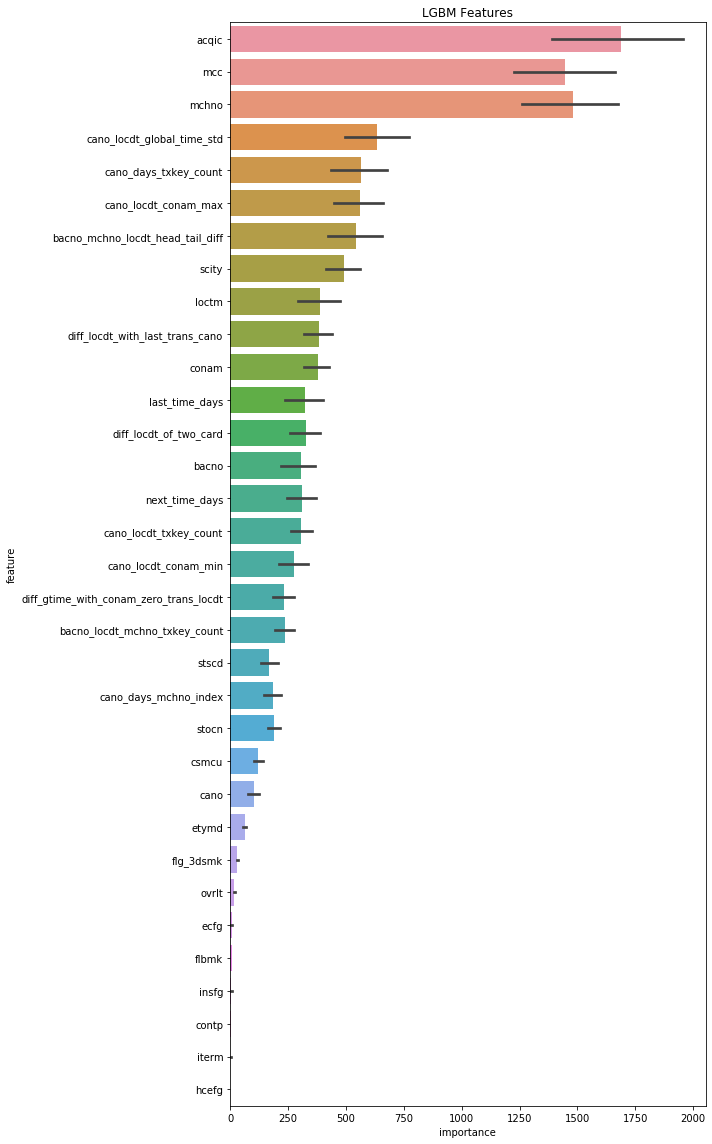

In [9]:
plot_importance(lgbm.df_feature_importance)